<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 5


## NLP and Machine Learning on [travel.statsexchange.com](http://travel.stackexchange.com/) data

---

In Project 7 you'll be doing NLP and machine learning on post data from stackexchange's travel subdomain. 

This project is setup like a mini Kaggle competition. You are given the training data and when projects are submitted your model will be tested on the held-out testing data. There will be prizes for the people who build models that perform best on the held out test set!

---

## Notes on the data

The data is again compressed into the `.7z` file format to save space. There are 6 .csv files and one readme file that contains some information on the fields.

    posts_train.csv
    comments_train.csv
    users.csv
    badges.csv
    votes_train.csv
    tags.csv
    readme.txt
    
The data is located in your datasets folder:

    DSI-SF-2/datasets/stack_exchange_travel.7z
    
If you're interested in where this data came from and where to get more data from other stackexchange subdomains, see here:

https://ia800500.us.archive.org/22/items/stackexchange/readme.txt


### Recommended Utilities for .7z

- For OSX [Keka](http://www.kekaosx.com/en/) or [The Unarchiver](http://wakaba.c3.cx/s/apps/unarchiver.html). 
- For Windows [7-zip](http://www.7-zip.org/) is the standard. 
- For Linux try the `p7zip` utility.  `sudo apt-get install p7zip`.



In [1]:
# Lets use notes from: 
#  4.2_Intro_Topic_Models_Lecture 
#  4.2_topic-modeling_lab 

In [42]:
import sklearn
# Import all of the scikit learn stuff
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

#from gensim import corpora, models, matutils
from gensim import corpora, models, matutils

from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

%matplotlib inline

import warnings

# Suppress warnings from pandas library
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pandas", lineno=570)


In [3]:
# import data
posts_df = pd.read_csv('~/Desktop/DSI-SF-5/datasets/stack_exchange_travel/posts_train.csv')
comments_df = pd.read_csv('~/Desktop/DSI-SF-5/datasets/stack_exchange_travel/comments_train.csv')
tags_df = pd.read_csv('~/Desktop/DSI-SF-5/datasets/stack_exchange_travel/tags.csv')



In [4]:
# Look at datasets

posts_df.head(2).T

,0,1
AcceptedAnswerId,393,NaN
AnswerCount,4,1
Body,<p>My fiancée and I are looking for a good Car...,<p>Singapore Airlines has an all-business clas...
ClosedDate,2013-02-25T23:52:47.953,NaN
CommentCount,4,1
CommunityOwnedDate,NaN,NaN
CreationDate,2011-06-21T20:19:34.730,2011-06-21T20:24:57.160
FavoriteCount,NaN,NaN
Id,1,4
LastActivityDate,2012-05-24T14:52:14.760,2013-01-09T09:55:22.743


In [5]:
posts_df.info()
posts_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41289 entries, 0 to 41288
Data columns (total 21 columns):
AcceptedAnswerId         6516 non-null float64
AnswerCount              13988 non-null float64
Body                     40476 non-null object
ClosedDate               2627 non-null object
CommentCount             41289 non-null int64
CommunityOwnedDate       181 non-null object
CreationDate             41289 non-null object
FavoriteCount            3522 non-null float64
Id                       41289 non-null int64
LastActivityDate         41289 non-null object
LastEditDate             23363 non-null object
LastEditorDisplayName    844 non-null object
LastEditorUserId         22883 non-null float64
OwnerDisplayName         1173 non-null object
OwnerUserId              40552 non-null float64
ParentId                 23967 non-null float64
PostTypeId               41289 non-null int64
Score                    41289 non-null int64
Tags                     13988 non-null object
Titl

(41289, 21)

In [6]:
# see how much nulls
posts_df.isnull().sum()

AcceptedAnswerId         34773
AnswerCount              27301
Body                       813
ClosedDate               38662
CommentCount                 0
CommunityOwnedDate       41108
CreationDate                 0
FavoriteCount            37767
Id                           0
LastActivityDate             0
LastEditDate             17926
LastEditorDisplayName    40445
LastEditorUserId         18406
OwnerDisplayName         40116
OwnerUserId                737
ParentId                 17322
PostTypeId                   0
Score                        0
Tags                     27301
Title                    27301
ViewCount                27301
dtype: int64

In [7]:
# look at text of post in "Body" column
posts_df["Body"][0]

"<p>My fianc\xc3\xa9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?</p>\n\n<p>It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.</p>\n\n<p><strong>EDIT</strong> We'll be travelling in 2012.</p>\n"

In [8]:
from bs4 import BeautifulSoup

# 1. Remove HTML
#review_text_no_html = BeautifulSoup(review, "lxml").get_text()
review = posts_df["Body"][0]

BeautifulSoup(review, "lxml").get_text()

u"My fianc\xe9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?\nIt seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.\nEDIT We'll be travelling in 2012.\n"

In [9]:
posts_df["Body"] = posts_df['Body'].map(lambda x: BeautifulSoup(str(x),"lxml").get_text())  # Remove HTML from "Body" column

In [10]:
posts_df["Body"][0]

u"My fianc\xe9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?\nIt seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.\nEDIT We'll be travelling in 2012.\n"

In [11]:
posts_df["Body"] = posts_df["Body"].map(lambda x: x.replace('\n',' ')) # remove "\n" from "Body" column

In [12]:
posts_df["Body"][0]

u"My fianc\xe9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take? It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options. EDIT We'll be travelling in 2012. "

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 1. Use LDA to find what topics are discussed on travel.stackexchange.com.

---

Text can be found in the posts and the comments datasets. The `ParentId` column in the posts dataset indicates what the "question" post was for a given post. Comment text can be merged onto the post they are part of with the `PostId` field.

The text may have some HTML tags. BeautifulSoup has convenient ways to get rid of markup or extract text if you need to. You can also parse the strings yourself if you like.

The tags dataset has the "tags" that the users have officially given the post.

**1.1 Implement LDA against the text features of the dataset(s).**

- This can be posts or a combination of posts and comments if you want more power.
- Find optimal **K/num_topics**.

**1.2 Compare your topics to the tags. Do the LDA topics make sense? How do they compare to the tags?**


In [13]:
##### 1.1 Implement LDA against the text features of the dataset(s). ############

In [14]:
text_df= posts_df[["Body"]] # DataFrame with just Posts text

# number of topics
k     =  10

# Vectorize
vectorizer  =  CountVectorizer(stop_words='english')
X           =  vectorizer.fit_transform(text_df["Body"])

# This is the fastest way to swap a dictionary key / value order.  This is the format gensim LDA expects it's vocabulary.
vocab = {v: k for k, v in vectorizer.vocabulary_.iteritems()}



In [15]:
# Look at vocabulary
#vocab

In [16]:
# LDA model
lda = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  k,
    passes      =  10,
    id2word     =  vocab
)

In [17]:
# Look at the topics found
lda.print_topics(num_topics=10, num_words=5)

[(0,
  u'0.038*"airport" + 0.019*"bus" + 0.018*"hours" + 0.014*"time" + 0.010*"terminal"'),
 (1,
  u'0.014*"luggage" + 0.012*"check" + 0.010*"security" + 0.008*"baggage" + 0.008*"bag"'),
 (2,
  u'0.027*"card" + 0.013*"use" + 0.012*"bank" + 0.011*"credit" + 0.011*"pay"'),
 (3,
  u'0.046*"visa" + 0.018*"passport" + 0.014*"uk" + 0.012*"need" + 0.012*"country"'),
 (4,
  u'0.013*"people" + 0.006*"don" + 0.006*"water" + 0.005*"like" + 0.005*"just"'),
 (5,
  u'0.024*"train" + 0.019*"ticket" + 0.016*"http" + 0.015*"www" + 0.012*"tickets"'),
 (6,
  u'0.012*"like" + 0.010*"time" + 0.009*"just" + 0.008*"want" + 0.007*"hotel"'),
 (7,
  u'0.013*"countries" + 0.012*"english" + 0.012*"south" + 0.010*"russia" + 0.009*"border"'),
 (8,
  u'0.009*"expired" + 0.008*"island" + 0.007*"sea" + 0.007*"islands" + 0.006*"north"'),
 (9,
  u'0.027*"flight" + 0.016*"ticket" + 0.013*"airline" + 0.013*"flights" + 0.012*"airlines"')]

In [18]:
##### 1.2 Compare your topics to the tags. START
##### Do the LDA topics make sense? 
##### How do they compare to the tags?

In [19]:
# Look at "Tags" column:

posts_df["Tags"].value_counts()

<visas><schengen>                                                                    120
<visas>                                                                               64
<visas><uk>                                                                           64
<air-travel>                                                                          61
<schengen>                                                                            45
<visas><usa>                                                                          29
<passports>                                                                           20
<transit>                                                                             20
<air-travel><luggage>                                                                 17
<customs-and-immigration>                                                             17
<luggage>                                                                             17
<air-travel><tickets>

In [20]:
tags_list = []
for tag in posts_df["Tags"]:
    for t in tag.split():
        tags_list.append(t)

AttributeError: 'float' object has no attribute 'split'

In [21]:
##### 1.2 Compare your topics to the tags. END
#####
##### Do the LDA topics make sense? Yes, the LDA Topics are related to travel
##### LDA Topics discoverd
# (0, u'0.042*"flight" + 0.028*"airport" + 0.017*"check" + 0.015*"flights" + 0.015*"luggage"'),
# ==> Air travel
# (1, u'0.026*"days" + 0.018*"stay" + 0.017*"time" + 0.014*"day" + 0.013*"trip"'),
# ==> 
# (2, u'0.008*"water" + 0.008*"food" + 0.006*"carry" + 0.006*"like" + 0.006*"just"'),
# (3, u'0.024*"car" + 0.010*"road" + 0.009*"drive" + 0.008*"driving" + 0.007*"park"'),
# (4, u'0.057*"visa" + 0.023*"passport" + 0.016*"uk" + 0.014*"schengen" + 0.014*"country"'),
# (5, u'0.030*"train" + 0.022*"bus" + 0.016*"station" + 0.014*"ticket" + 0.012*"trains"'),
# (6, u'0.013*"card" + 0.011*"ticket" + 0.009*"pay" + 0.007*"use" + 0.007*"booking"'),
# (7, u'0.013*"people" + 0.009*"like" + 0.009*"just" + 0.007*"don" + 0.007*"know"'),
# (8, u'0.013*"esta" + 0.012*"south" + 0.009*"city" + 0.009*"mexico" + 0.008*"new"'),
# (9, u'0.032*"http" + 0.031*"www" + 0.024*"com" + 0.013*"00" + 0.012*"https"')]

##### How do they compare to the tags? The LDA Topics have some of the same/simlar as Tags
### Top Tags in frequency
# <visas><schengen>                                                                    120
# <visas>                                                                               64
# <visas><uk>                                                                           64
# <air-travel>                                                                          61
# <schengen>                                                                            45
# <visas><usa>                                                                          29
# <passports>                                                                           20
# <transit>                                                                             20
# <air-travel><luggage>                                                                 17
# <customs-and-immigration>                                                             17

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2. What makes an answer likely to be "accepted"?

---

**2.1 Build a model to predict whether a post will be marked as the answer.**

- This is a classification problem.
- You're free to use any of the machine learning algorithms or techniques we have learned in class to build the best model you can.
- NLP will be very useful here for pulling out useful and relevant features from the data. 
- Though not required, using bagging and boosting models like Random Forests and Gradient Boosted Trees will _probably_ get you the highest performance on the test data (but who knows!).


**2.2 Evaluate the performance of your classifier with a confusion matrix and accuracy. Explain how your model is performing.**

**2.3 Plot either a ROC curve or precision-recall curve (or both!) and explain what they tell you about your model.**

NOTE: You should only be predicting this for `PostTypeID=2` posts, which are the "answer" posts. This doesn't mean, however, that you can't or shouldn't use the parent questions as predictors!


In [23]:
# Use CountVectorizer 
cv = CountVectorizer(ngram_range=(1,2), max_features=2500, binary=True, stop_words='english')
body = cv.fit_transform(posts_df['Body'])

body_text = pd.DataFrame(body.todense(), columns=cv.get_feature_names())


In [24]:
posts_df['PostTypeId'].value_counts()

2    23967
1    13988
5     1656
4     1656
6       18
7        4
Name: PostTypeId, dtype: int64

In [25]:
posts_df['PostTypeId'] = posts_df['PostTypeId'].map(lambda x: 1 if x == 2 else 0) # 2 Answer vs Non Answer Post

In [26]:
body_text.head()

,00,000,10,10 days,10 minutes,10 years,100,1000,11,12,...,years old,yellow,yes,york,young,zealand,zero,zone,zones,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
X = body_text.values          # predictors, X
y = posts_df["PostTypeId"]    # target, y

In [43]:
# test train split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)

lr_scores = cross_val_score(lr, Xtest, ytest, cv=5)

print("R2")
print(np.mean(lr_scores))


R2
0.830547966229


In [44]:
# PLOT ROC curve

from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    fpr_, tpr_, _ = roc_curve(y, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname + 'not ' + varname)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()

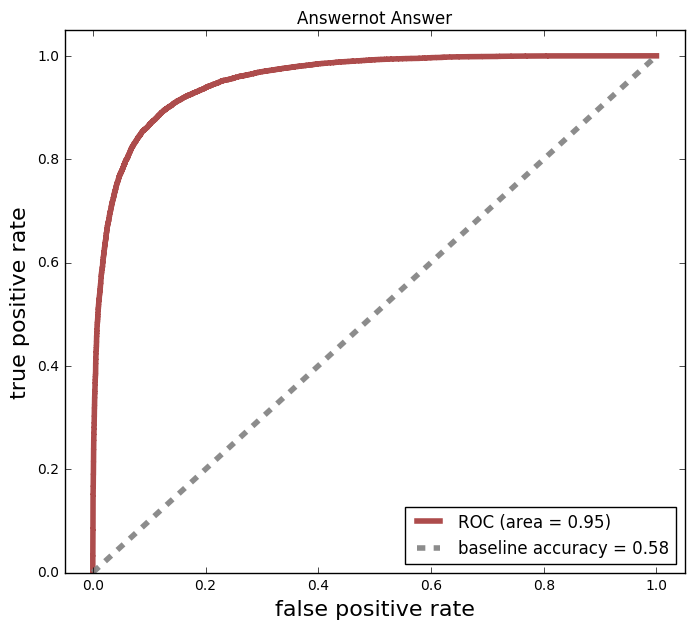

In [45]:
# # PLOT ROC curve - Answer vs not Answer
plot_roc(lr, X, y, 'Answer')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 3. What is the score of a post?

---

**3.1 Build a model that predicts the score of a post.**

- This is a regression problem now. 
- You can and should be predicting score for both "question" and "answer" posts, so keep them both in your dataset.
- Again, use any techniques that you think will get you the best model.

**3.2 Evaluate the performance of your model with cross-validation and report the results.**

**3.3 What is important for determining the score of a post, if anything?**


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4. How many views does a post have?

---

**4.1 Build a model that predicts the number of views a post has.**

- This is another regression problem. 
- Predict the views for all posts, not just the "answer" posts.

**4.2 Evaluate the performance of your model with cross-validation and report the results.**

**4.3 What is important for the number of views a post has, if anything?**

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5. Build a pipeline or other code to automate evaluation of your models on the test data.

---

Now that you've constructed your three predictive models, build a pipeline or code that can easily load up the raw testing data and evaluate your models on it.

The testing data that is held out is in the same raw format as the training data you have. _Any cleaning and preprocessing that you did on the training data will need to be done on the testing data as well!_

This is a good opportunity to practice building pipelines, but you're not required to. Custom functions and classes are fine as long as they are able to process and test the new data.


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Lets Model - Tournament for stock market predictions

>Start this section of the project by downloading the train and test datasets from the following site: https://numer.ai/rules

> - The data set is clean, your goal is to develop a classification model(s) 
> - Report all the results including log loss, and other coefficients you consider iteresting